In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

**Data load and Encoder Input**

In [2]:
df = pd.read_csv("/content/drive/MyDrive/cricket_shot_feedback_dataset_FINAL.csv")

numeric_cols = [
    "confidence", "bat_angle", "hit_quality",
    "face_stability", "stance_bend",
    "front_foot_stance_score", "shot_accuracy"
]

scaler = MinMaxScaler()
X_num = scaler.fit_transform(df[numeric_cols])

shot_encoder = OneHotEncoder(sparse_output=False)
X_shot = shot_encoder.fit_transform(df[["shot_type"]])

X_encoder = np.concatenate([X_num, X_shot], axis=1)

**Tokenization**

In [5]:
import re
texts = []

for sentence in df["feedback_paragraph"]:
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-z\s]', '', sentence)   # ✅ CLEAN
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    sentence = "<start> " + sentence + " <end>"
    texts.append(sentence)

**Split Words**

In [6]:
tokenized_texts = []

for sentence in texts:
    words = sentence.split(" ")
    tokenized_texts.append(words)

**Build Vocabulary**

In [7]:
# Build vocabulary (PAD must be index 0)
vocab = ["<pad>"]

for sentence in tokenized_texts:
    for word in sentence:
        if word not in vocab:
            vocab.append(word)

**Word to Index Mapping**

In [8]:
word2idx = {}
idx2word = {}

for i, word in enumerate(vocab):
    word2idx[word] = i
    idx2word[i] = word

vocab_size = len(word2idx)
print("Vocabulary size:", vocab_size)

Vocabulary size: 35


**Convert Words to Sequences**

In [9]:
sequences = []

for sentence in tokenized_texts:
    seq = []
    for word in sentence:
        seq.append(word2idx[word])
    sequences.append(seq)

**Manual Padding**

In [10]:
# Determine maximum sequence length
max_len = max(len(seq) for seq in sequences)

# Pad sequences with <pad> token
padded_sequences = np.array([
    seq + [word2idx["<pad>"]] * (max_len - len(seq))
    for seq in sequences
])

**Decoder Input & Target**

In [11]:
# Decoder input: all tokens except the last one
decoder_input = padded_sequences[:, :-1]

# Decoder target: all tokens except the first one
decoder_target = padded_sequences[:, 1:]

# Convert targets to one-hot vectors for categorical crossentropy
decoder_target = to_categorical(decoder_target, num_classes=vocab_size)#[0, 0, 0, 1, 0]

**Encoder–Decoder LSTM Model**

In [12]:
encoder_input = Input(shape=(X_encoder.shape[1],))
x = Dense(64, activation="relu")(encoder_input)#convert these into hidden representations

state_h = Dense(64, activation="tanh")(x)
state_c = Dense(64, activation="tanh")(x)

decoder_input_layer = Input(shape=(max_len - 1,))
embedding = Embedding(vocab_size, 64, mask_zero=True)(decoder_input_layer)

decoder_lstm = LSTM(
    64,
    return_sequences=True,
    return_state=True
)

decoder_output, _, _ = decoder_lstm(
    embedding,
    initial_state=[state_h, state_c]
)

output = Dense(vocab_size, activation="softmax")(decoder_output)

model = Model([encoder_input, decoder_input_layer], output)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 25, 64)    │      2,240 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 25, 64),  │     33,024 │ embedding[0][0],  │
│                     │ (None, 64),       │            │ dense_1[0][0],    │
│                     │ (None, 64)]       │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25, 35)    │      2,275 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,691 (182.39 KB)

 Trainable params: 46,691 (182.39 KB)

 Non-trainable params: 0 (0.00 B)

**Train, Save, Plot**

Epoch 1/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2855 - loss: 3.2666 - val_accuracy: 0.5793 - val_loss: 2.0411
Epoch 2/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6562 - loss: 1.6449 - val_accuracy: 0.8107 - val_loss: 0.8053
Epoch 3/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8347 - loss: 0.6791 - val_accuracy: 0.8623 - val_loss: 0.4439
Epoch 4/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8725 - loss: 0.4012 - val_accuracy: 0.8733 - val_loss: 0.3279
Epoch 5/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8818 - loss: 0.3060 - val_accuracy: 0.8850 - val_loss: 0.2755
Epoch 6/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8909 - loss: 0.2605 - val_accuracy: 0.8896 - val_loss: 0.2464
Epoch 7/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8935 - loss: 0.2353 - val_accuracy: 0.8951 - val_loss: 0.2240
Epoch 8/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8986 - loss: 0.2182 - val_accuracy: 0.9010 - v

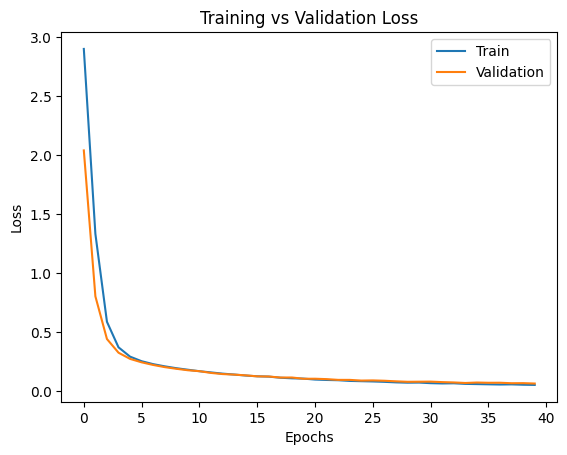

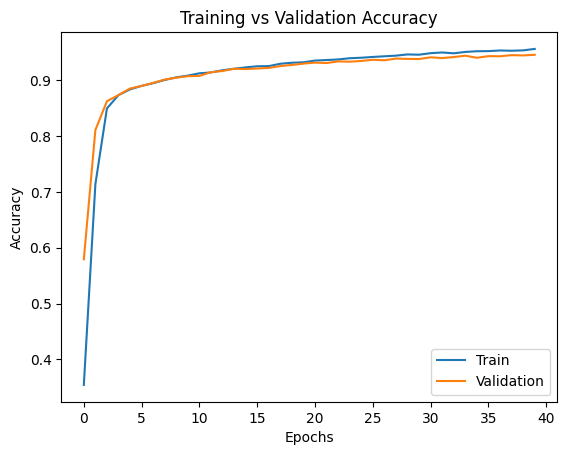

In [13]:
history = model.fit(
    [X_encoder, decoder_input],
    decoder_target,
    epochs=40,
    batch_size=64,
    validation_split=0.1
)

# Save model and preprocessing objects
model.save("/content/drive/MyDrive/cric_feedback_model_final.keras")
pickle.dump(word2idx, open("/content/drive/MyDrive/word2idx.pkl", "wb"))
pickle.dump(idx2word, open("/content/drive/MyDrive/idx2word.pkl", "wb"))
pickle.dump(scaler, open("/content/drive/MyDrive/scaler.pkl", "wb"))
pickle.dump(shot_encoder, open("/content/drive/MyDrive/shot_encoder.pkl", "wb"))

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(
    "/content/drive/MyDrive/training_metrics.csv",
    index=False
)

# Plot Loss
plt.figure()
plt.plot(history_df["loss"])
plt.plot(history_df["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(["Train", "Validation"])
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(history_df["accuracy"])
plt.plot(history_df["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

**EVALUATION**

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import re

# ------------------------------
# 1️⃣ Load trained model & preprocessing
# ------------------------------
model = tf.keras.models.load_model("/content/drive/MyDrive/cric_feedback_model_final.keras")

word2idx = pickle.load(open("/content/drive/MyDrive/word2idx.pkl", "rb"))
idx2word = pickle.load(open("/content/drive/MyDrive/idx2word.pkl", "rb"))

scaler = pickle.load(open("/content/drive/MyDrive/scaler.pkl", "rb"))
shot_encoder = pickle.load(open("/content/drive/MyDrive/shot_encoder.pkl", "rb"))

# ------------------------------
# 2️⃣ Load full test data
# ------------------------------
test_df = pd.read_csv('/content/drive/MyDrive/u222nique_feedback_paragraphs.csv')

MAX_LEN = model.input[1].shape[1]  # decoder input length
numeric_cols = ["confidence", "bat_angle", "hit_quality", "face_stability",
                "stance_bend", "front_foot_stance_score", "shot_accuracy"]

# ------------------------------
# 3️⃣ Utilities
# ------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove non-alphabetic chars
    text = text.replace("<start>", "").replace("<end>", "")
    text = re.sub(r"\s+", " ", text).strip()  # normalize spaces
    return text

def generate_feedback(x_enc, max_len=MAX_LEN):
    seq = [word2idx["<start>"]]
    words = []

    for i in range(max_len):
        padded = pad_sequences([seq], maxlen=max_len, padding="post")
        preds = model.predict([x_enc, padded], verbose=0)
        next_id = np.argmax(preds[0, len(seq)-1, :])
        if next_id == word2idx["<end>"]:
            break
        seq.append(next_id)
        words.append(idx2word.get(next_id, "<unk>"))

    return " ".join(words)

# ------------------------------
# 4️⃣ Full inference & word-level accuracy ignoring order
# ------------------------------
real_paragraphs = []
predicted_paragraphs = []
per_row_accuracy = []

total_words = 0
correct_words = 0

for i, row in test_df.iterrows():
    # Prepare encoder input
    X_num_scaled = scaler.transform(pd.DataFrame([row[numeric_cols]], columns=numeric_cols))
    X_shot_encoded = shot_encoder.transform(pd.DataFrame([row[["shot_type"]]], columns=["shot_type"]))
    X_enc = np.concatenate([X_num_scaled, X_shot_encoded], axis=1)

    # Generate prediction
    predicted = generate_feedback(X_enc)
    real = row["feedback_paragraph"]

    # Clean text
    predicted_clean = clean_text(predicted)
    real_clean = clean_text(real)

    real_paragraphs.append(real_clean)
    predicted_paragraphs.append(predicted_clean)

    # Token-level comparison ignoring order
    real_set = set(real_clean.split())
    pred_set = set(predicted_clean.split())

    # Avoid division by zero
    row_accuracy = len(real_set.intersection(pred_set)) / len(real_set) * 100 if len(real_set) > 0 else 0
    per_row_accuracy.append(row_accuracy)

    # Update overall counters
    total_words += len(real_set)
    correct_words += len(real_set.intersection(pred_set))

    # Print row output
    print(f"Row {i+1} | Word-Level Accuracy : {row_accuracy:.2f}%")
    print("REAL      :", real_clean)
    print("PREDICTED :", predicted_clean)
    print("-" * 60)

# Final word-level accuracy across all rows
word_accuracy = correct_words / total_words * 100 if total_words > 0 else 0
print(f"\nFINAL WORD-LEVEL ACCURACY : {word_accuracy:.2f}%")

# ------------------------------
# 5️⃣ Save results
# ------------------------------
output_df = pd.DataFrame({
    "Real Paragraph": real_paragraphs,
    "Predicted Paragraph": predicted_paragraphs,
    "Word-Level Accuracy %": per_row_accuracy
})
output_df.to_csv('/content/drive/MyDrive/real_vs_predicted_feedback_all_ignore_order.csv', index=False)

Row 1 | Word-Level Accuracy : 100.00%
REAL      : good sweep shot bat angle hit quality provide controlled execution weak stance bend reduce shot effectiveness improving confidence will add consistency
PREDICTED : good sweep shot bat angle hit quality provide controlled execution weak stance bend reduce shot effectiveness improving confidence will add consistency
------------------------------------------------------------
Row 2 | Word-Level Accuracy : 100.00%
REAL      : good cover shot face stability shot accuracy provide controlled execution weak bat angle reduce shot effectiveness improving front foot stance score will add consistency
PREDICTED : good cover shot face stability shot accuracy provide controlled execution weak bat angle reduce shot effectiveness improving front foot stance score will add consistency
------------------------------------------------------------
Row 3 | Word-Level Accuracy : 94.44%
REAL      : excellent sweep shot bat angle hit quality stance bend provid

Sentence similarity (cosine using TF-IDF)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(real_paragraphs + predicted_paragraphs)

real_vecs = tfidf[:len(real_paragraphs)]
pred_vecs = tfidf[len(real_paragraphs):]

sentence_similarity = cosine_similarity(real_vecs, pred_vecs).diagonal().mean()
print(f"SENTENCE-LEVEL COSINE SIMILARITY: {sentence_similarity*100:.2f}%")

SENTENCE-LEVEL COSINE SIMILARITY: 89.89%


Save results CSV

In [24]:
output_df = pd.DataFrame({
    "Real Paragraph": real_paragraphs,
    "Predicted Paragraph": predicted_paragraphs
})
output_df.to_csv('/content/real_vs_predicted_feedback.csv', index=False)

Plot comparison of real vs predicted paragraph lengths

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import pandas as pd
import re

# ------------------------------
# 1️⃣ Load trained model & preprocessing
# ------------------------------
model = tf.keras.models.load_model("/content/drive/MyDrive/cric_feedback_model_final.keras")

word2idx = pickle.load(open("/content/drive/MyDrive/word2idx.pkl", "rb"))
idx2word = pickle.load(open("/content/drive/MyDrive/idx2word.pkl", "rb"))

scaler = pickle.load(open("/content/drive/MyDrive/scaler.pkl", "rb"))
shot_encoder = pickle.load(open("/content/drive/MyDrive/shot_encoder.pkl", "rb"))

MAX_LEN = model.input[1].shape[1]  # decoder input length
numeric_cols = ["confidence", "bat_angle", "hit_quality", "face_stability",
                "stance_bend", "front_foot_stance_score", "shot_accuracy"]

# ------------------------------
# 2️⃣ Utilities
# ------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove non-alphabetic chars
    text = text.replace("<start>", "").replace("<end>", "")
    text = re.sub(r"\s+", " ", text).strip()
    return text

def generate_feedback(x_enc, max_len=MAX_LEN):
    seq = [word2idx["<start>"]]
    words = []

    for _ in range(max_len):
        padded = pad_sequences([seq], maxlen=max_len, padding="post")
        preds = model.predict([x_enc, padded], verbose=0)
        next_id = np.argmax(preds[0, len(seq)-1, :])
        if next_id == word2idx["<end>"]:
            break
        seq.append(next_id)
        words.append(idx2word.get(next_id, "<unk>"))

    return " ".join(words)

# ------------------------------
# 3️⃣ Interactive Custom Input
# ------------------------------
while True:
    cont = input("\nDo you want to generate a feedback paragraph? (yes/no): ").strip().lower()
    if cont not in ["yes", "y"]:
        print("Exiting...")
        break

    # Read numeric inputs
    numeric_input = []
    for col in numeric_cols:
        while True:
            val = input(f"{col}: ").strip()
            try:
                numeric_input.append(float(val))
                break
            except:
                print("Invalid number. Please enter a valid float.")

    # Read shot type
    shot_type = input("shot_type: ").strip()
    if shot_type not in shot_encoder.categories_[0]:
        print("Unknown shot type! Available types:", shot_encoder.categories_[0])
        continue

    # Scale numeric values as DataFrame to avoid warnings
    X_num_scaled = scaler.transform(pd.DataFrame([numeric_input], columns=numeric_cols))
    X_shot_encoded = shot_encoder.transform(pd.DataFrame([[shot_type]], columns=["shot_type"]))

    # Concatenate encoder input
    X_enc = np.concatenate([X_num_scaled, X_shot_encoded], axis=1)

    # Generate feedback
    feedback = generate_feedback(X_enc)
    feedback_clean = clean_text(feedback)

    print("\n✅ Generated Feedback Paragraph:\n", feedback_clean)


Do you want to generate a feedback paragraph? (yes/no): yes
confidence: 80
bat_angle: 12
hit_quality: 88
face_stability: 78
stance_bend: 77
front_foot_stance_score: 44
shot_accuracy: 88
shot_type: pull

✅ Generated Feedback Paragraph:
 excellent pull shot confidence stance bend provide controlled execution weak front foot stance score reduce shot effectiveness improving bat angle will add consistency
